# Stock movement prediction 

In [19]:
%matplotlib inline

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import warnings
from stock_mv import *

plt.style.use('ggplot')
random_state=1
test_size = 0.2

In [2]:
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore", category=Warning)

### Get Data set from iexfinance

In [3]:
start = dt.datetime(2014,1,1)
end = dt.datetime.now()
symbol = "T"

In [4]:
from iexfinance import get_historical_data 
stock = get_historical_data(symbol, start=start, end=end, output_format='pandas')
print(stock.shape,stock.index[0],stock.index[-1])

stock.head(3)

(1259, 5) 2014-01-21 2019-01-18


,open,high,low,close,volume
date,,,,,
2014-01-21,26.2233,26.3472,25.7273,26.0140,29421880
2014-01-22,26.0373,26.0838,25.8125,25.8358,17557647
2014-01-23,25.7428,26.1923,25.6886,26.1923,28543368



## Feature engineering
* add technical analysis indicators

In [5]:
import talib as ta

In [6]:
df = stock.copy(True)
# RSI
RSI_DAYS = 14 
df['rsi'] = ta.RSI(df['close'].values, RSI_DAYS)

# moving averages
df['sma5'] = df['close'].rolling(5).mean()
df['sma10'] = df['close'].rolling(10).mean()
df['sma20'] = df['close'].rolling(window=20).mean()
df['sma50'] = df['close'].rolling(window=50).mean()

SMA_SLOW = 10
SMA_FAST = 3 
EMA_SLOW = 13 
EMA_FAST = 6
df['sma_diff'] = (df['close'].rolling(window=SMA_SLOW).mean() - df['close'].rolling(window=SMA_FAST).mean())
df['ema_diff'] = ta.EMA(df['close'].values, EMA_SLOW) - ta.EMA(df['close'].values, EMA_FAST)

# MACD - moving average convergence divergence
df['macd'] = (df['close'].ewm(span=12,adjust=False).mean() - df['close'].ewm(span=26,adjust=False).mean())
df['macd_signal'] = df['macd'].ewm(span=9,adjust=False).mean()

# ADX
df['adx'] = ta.ADX(df['high'].values,df['low'].values,df['close'].values, timeperiod=14)

In [7]:
# candlestick
## -day1
df['ho'] = (df['high'] - df['open'])/df['open']
df['lo'] = (df['low'] - df['open'])/df['open']
df['co'] = (df['close'] - df['open'])/df['open']
df['upper_shadow'] = (df['high']-df[['open','close']].max(axis=1))/df['open']
df['lower_shadow'] = (df[['open','close']].min(axis=1) - df['low'])/df['open']

# more vars
df['vma20'] = df['volume'].shift(1).rolling(20).mean()
df['volume_vma20_ratio'] = df['volume']/df['vma20']
df['price_sma5_ratio'] = df['close']/df['sma5']

df['daily_change'] = df['close']-df['close'].shift(1)
df['move'] = np.where(df['daily_change'] >=0,'Up','Down')
df['move'] = df['move'].map({'Up':1,'Down':0})


## Add response variable
* class_1 = next day's movement
* class_2 = day after next's movement
* class_3 = 2 days after next's movement

In [8]:
df['class_1'] = df['move'].shift(-1)
df['class_2'] = df['move'].shift(-2)
df['class_3'] = df['move'].shift(-3)

In [9]:
df.drop(columns=['open','high','low'],inplace=True)

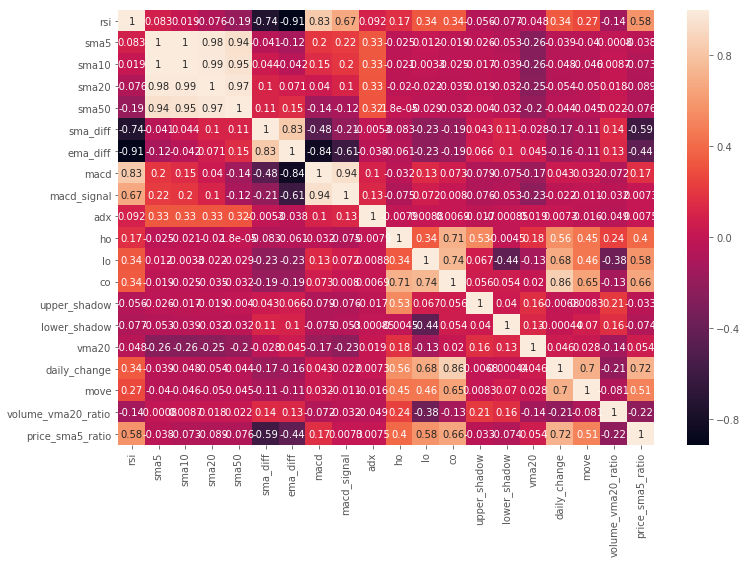

In [20]:
plt.figure(figsize=(12,8))
sns.heatmap(df.drop(columns=['close','volume','class_1','class_2','class_3']).corr(), annot=True)

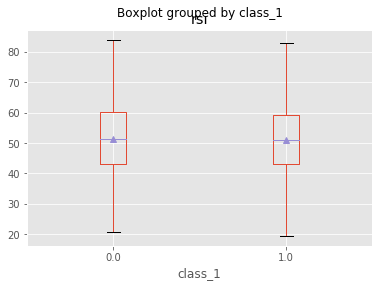

In [21]:
df.boxplot(column='rsi', by='class_1',showmeans=True)

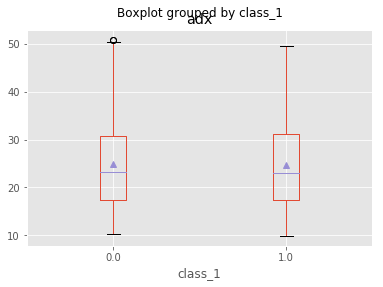

In [22]:
df.boxplot(column='adx', by='class_1',showmeans=True)

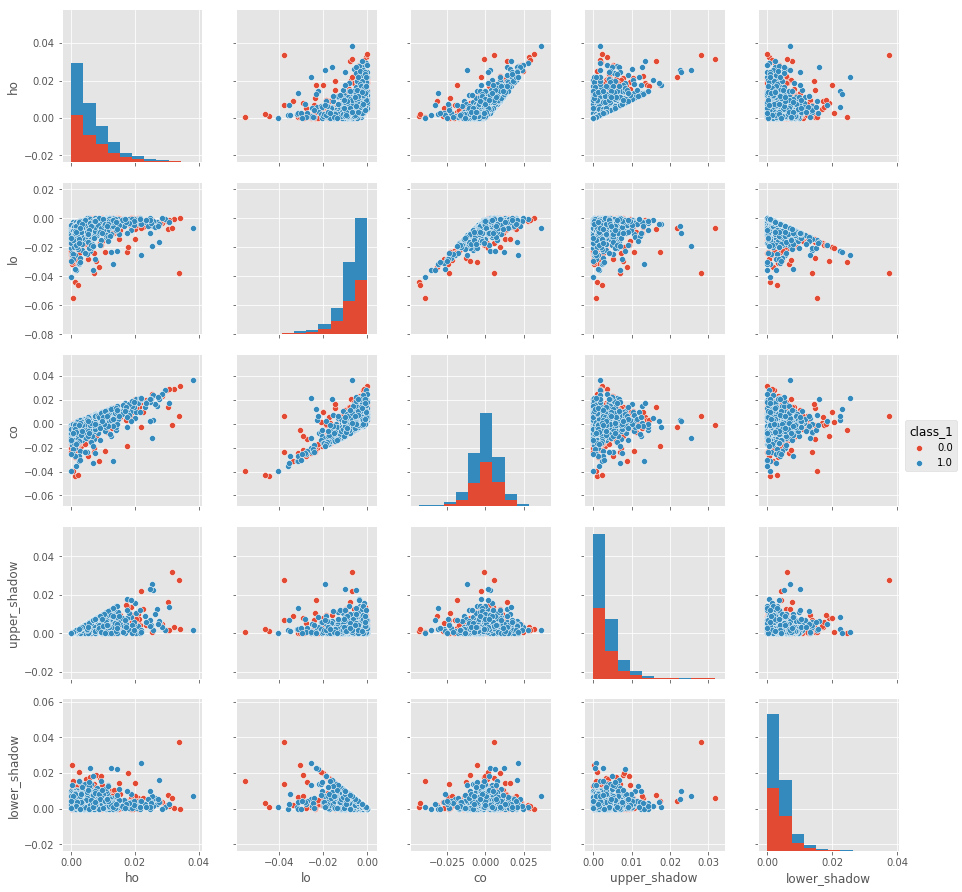

In [23]:
# candlestick pairplot
pairplot1 = sns.pairplot(df.dropna(), diag_kind='hist', vars=['ho','lo','co','upper_shadow','lower_shadow'], dropna=True, hue='class_1')
pairplot1.savefig('pairplot_candlestick.png')

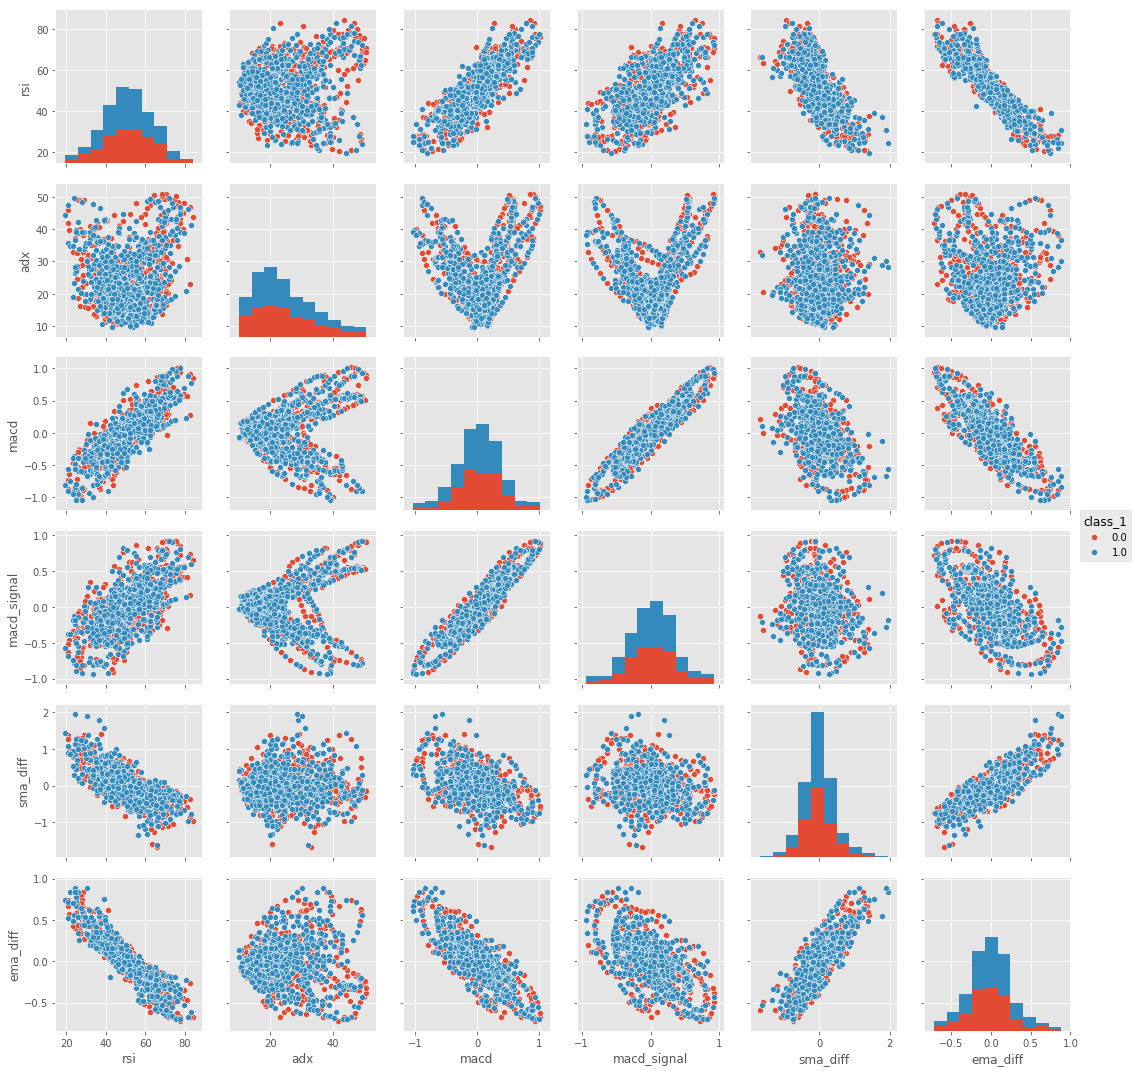

In [24]:
# indicator pairplot
pairplot2 = sns.pairplot(df.dropna(), diag_kind='hist',vars=['rsi','adx','macd','macd_signal','sma_diff','ema_diff'],dropna=True, hue='class_1')
pairplot2.savefig('pairplot-indicators.png')

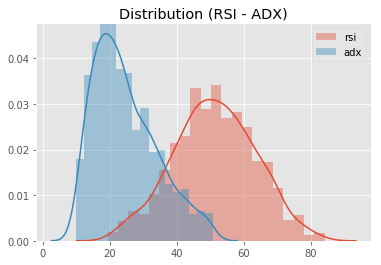

In [25]:
fig, ax=plt.subplots()
sns.distplot(df.dropna()['rsi'], label='rsi')
sns.distplot(df.dropna()['adx'], label='adx')
ax.legend(loc='best')
ax.set_title('Distribution (RSI - ADX)')
ax.set_xlabel('')
fig.savefig('distribution_indicator1.png')

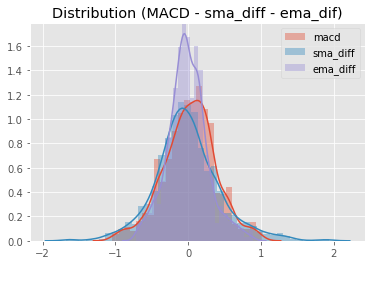

In [26]:
fig, ax = plt.subplots()
sns.distplot(df.dropna()['macd'], label='macd')
sns.distplot(df.dropna()['sma_diff'], label='sma_diff')
sns.distplot(df.dropna()['ema_diff'], label='ema_diff')
ax.legend(loc='best')
ax.set_title('Distribution (MACD - sma_diff - ema_dif)')
ax.set_xlabel(' ')
fig.savefig('distribution_indicator2.png')

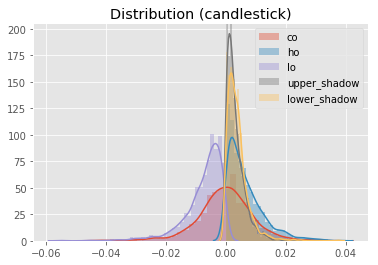

In [27]:
fig3, ax = plt.subplots()
sns.distplot(df.dropna()['co'], label='co')
sns.distplot(df.dropna()['ho'], label='ho')
sns.distplot(df.dropna()['lo'], label='lo')
sns.distplot(df.dropna()['upper_shadow'], label='upper_shadow')
sns.distplot(df.dropna()['lower_shadow'], label='lower_shadow')
ax.legend(loc='best')
ax.set_title('Distribution (candlestick)')
ax.set_xlabel('')
fig3.savefig('distribution_candlestick.png')

In [29]:
days_in_future = 3
forecast_data = df[-days_in_future:]
df = df.iloc[0:-days_in_future].dropna()
print(df.shape), print(df.index[0]), print(df.index[-1])

y_cols= ['class_1','class_2','class_3']

(1204, 25)
2014-04-01
2019-01-10


## Feature Selection 
* Recursive feature elimination
    * feature evaluator
        * decisiontree classifier 
        * max_depth range of (2-20)
    * space of features sets
        * 14 feature groups of any combination  
    * algorithm
        1. start with group[0], as a subset
        2. evaluate the subset and rank each feature variable using importance
        3. eliminate the one with lowest rank and get a new subset of features
        4. repeat 2 & 3 unitil the subset contains only 2 variables
        5. return the top 2 subsest with highest score for each response variable
        6. repeat step 1 to 5 for the rest of feature groups     

In [30]:
feature_groups = []
feature_groups.append(['rsi', 'macd', 'ema_diff', 'co', 'volume_vma20_ratio', 'price_sma5_ratio'])
feature_groups.append(['rsi','adx','sma_diff','ema_diff', 'ho', 'lo','co','upper_shadow','volume_vma20_ratio'])
feature_groups.append(['adx','sma_diff','ema_diff','ho','lo','co','upper_shadow','volume_vma20_ratio'])
feature_groups.append(['rsi', 'adx', 'co', 'volume_vma20_ratio', 'price_sma5_ratio'])
feature_groups.append(['adx','macd','ho','co','lower_shadow','volume_vma20_ratio','price_sma5_ratio'],)
feature_groups.append(['rsi','macd','sma_diff','ema_diff','ho','co','lower_shadow','volume_vma20_ratio',
                       'price_sma5_ratio'])
feature_groups.append(['rsi','adx','sma_diff','ema_diff','lo','ho','lower_shadow','macd'])
feature_groups.append(['rsi','macd','sma_diff','ema_diff','ho','lo','co','lower_shadow','price_sma5_ratio'])
feature_groups.append(['adx', 'macd', 'ho', 'lo', 'volume_vma20_ratio', 'price_sma5_ratio'])

feature_groups.append(['rsi', 'macd', 'sma_diff', 'ema_diff', 'ho', 'price_sma5_ratio'])
feature_groups.append(['macd', 'sma_diff', 'ema_diff', 'ho', 'price_sma5_ratio'])
feature_groups.append(['rsi','adx','sma_diff','ema_diff','ho','lo','co','volume_vma20_ratio'])
feature_groups.append(['ema_diff','lo','co','upper_shadow','volume_vma20_ratio','price_sma5_ratio'])
feature_groups.append(['sma_diff', 'lo', 'lower_shadow', 'volume_vma20_ratio', 'price_sma5_ratio'])

In [31]:
# recursive feature eliminating
fs_models = pd.DataFrame()
for class_key in y_cols:  
    for fg_id in range(0, len(feature_groups)):
        f_group = feature_groups[fg_id]        
        out = recursive_feature_evaluation(df,model='Dtree',feature_cols=f_group,class_col=class_key)        
        feature_id = str(fg_id)+'_'+out['feature_size'].astype(str)
        out.insert(0, 'feature_id', feature_id)
        out.insert(0, 'fg_id', fg_id)
        out.insert(0, 'model','Dtree')
        out.insert(0, 'label',class_key)
       
        fs_models = fs_models.append(out, ignore_index=True)
        
print(fs_models.shape)

(249, 14)


In [32]:
fs_models.groupby('label').agg({'accuracy':max,'precision':max,'recall':max})

,accuracy,precision,recall
label,,,
class_1,0.626556,0.625210,0.626556
class_2,0.593361,0.645506,0.593361
class_3,0.618257,0.620356,0.618257


In [33]:
# auto_sets contains 84 feature_cols that will be used for model evaluation
auto_sets = pd.DataFrame()
for index, row in fs_models[['label','fg_id']].drop_duplicates().iterrows():   
    auto_sets = auto_sets.append(fs_models[(fs_models['label']==row['label'])&(fs_models['fg_id']==row['fg_id'])].nlargest(2, 'accuracy'), ignore_index=True)


In [34]:
print(auto_sets.shape)
auto_sets.head(2)

(84, 14)


,label,model,fg_id,feature_id,accuracy,precision,recall,f1,roc_auc,score,clf,params,feature_size,feature_cols
0,class_1,Dtree,0,0_6,0.564315,0.563136,0.564315,0.563483,0.560666,0.476791,"DecisionTreeClassifier(class_weight=None, crit...",{'max_depth': 13},6,"[rsi, macd, ema_diff, co, volume_vma20_ratio, ..."
1,class_1,Dtree,0,0_5,0.531120,0.541174,0.531120,0.528304,0.537306,0.471722,"DecisionTreeClassifier(class_weight=None, crit...",{'max_depth': 11},5,"[volume_vma20_ratio, price_sma5_ratio, rsi, em..."


# Model Evaluation

## Decision Tree

In [35]:
tree_models = auto_sets.copy(True)
print(tree_models.shape)
tree_models.groupby('label').agg({'accuracy':max,'precision':max,'recall':max})

(84, 14)


,accuracy,precision,recall
label,,,
class_1,0.626556,0.625210,0.626556
class_2,0.593361,0.645506,0.593361
class_3,0.618257,0.620356,0.618257


### plot tree

In [36]:
tm = tree_models.nlargest(1,'accuracy')
clf = tm['clf'].iloc[0]
f_cols = tm['feature_cols'].iloc[0]
label = tm['label'].iloc[0]
out = model_eval(df.dropna(), model='Dtree', feature_cols=f_cols, y_col=label, max_depth=3)

print(tm['label'].iloc[0],tm['accuracy'].iloc[0],tm['precision'].iloc[0])
tree_plot(out['clf'], feature_cols=f_cols)

class_1 0.6265560165975104 0.6252097662850925


## RandomForest

In [37]:
randomF_models = model_eval(df, model='RF', n_estimators=50, feature_sets=auto_sets)

In [38]:
randomF_models.groupby('label').agg({'accuracy':max,'precision':max,'recall':max})

,accuracy,precision,recall
label,,,
class_1,0.580913,0.586386,0.580913
class_2,0.568465,0.591149,0.568465
class_3,0.601660,0.600160,0.601660


In [39]:
print(randomF_models.shape)
randomF_models.head(2)

(84, 13)


,label,model,feature_id,accuracy,precision,recall,f1,roc_auc,score,clf,params,feature_size,feature_cols
0,class_1,RF,0_6,0.560166,0.557953,0.560166,0.558095,0.555025,0.481061,"(DecisionTreeClassifier(class_weight=None, cri...","{'depth': 17, 'n_estimators': 50}",6,"[rsi, macd, ema_diff, co, volume_vma20_ratio, ..."
1,class_1,RF,0_5,0.580913,0.578834,0.580913,0.578660,0.575581,0.485971,"(DecisionTreeClassifier(class_weight=None, cri...","{'depth': 19, 'n_estimators': 50}",5,"[volume_vma20_ratio, price_sma5_ratio, rsi, em..."


## Knn

In [40]:
knn_models = model_eval(df, model='knn', feature_sets=auto_sets)

In [41]:
print(knn_models.shape)
knn_models.groupby('label').agg({'accuracy':max,'precision':max,'recall':max})

(84, 13)


,accuracy,precision,recall
label,,,
class_1,0.585062,0.594421,0.585062
class_2,0.614108,0.620001,0.614108
class_3,0.605809,0.604395,0.605809


In [43]:
print(knn_models.shape)
knn_models.head(2)

(84, 13)


,label,model,feature_id,accuracy,precision,recall,f1,roc_auc,score,clf,params,feature_size,feature_cols
0,class_1,knn,0_6,0.585062,0.594421,0.585062,0.583861,0.590047,0.511742,"Pipeline(memory=None,\n steps=[('standards...",{'k_value': 10},6,"[rsi, macd, ema_diff, co, volume_vma20_ratio, ..."
1,class_1,knn,0_5,0.560166,0.558750,0.560166,0.559111,0.556202,0.485055,"Pipeline(memory=None,\n steps=[('standards...",{'k_value': 13},5,"[volume_vma20_ratio, price_sma5_ratio, rsi, em..."


## Logistic Regression

In [45]:
logreg_models = model_eval(df, model='logReg', feature_sets=auto_sets)

In [46]:
logreg_models.groupby(['label'], as_index=False).agg({'accuracy':max,'precision':max,'recall':max})

,label,accuracy,precision,recall
0,class_1,0.560166,0.637639,0.560166
1,class_2,0.543568,0.753642,0.543568
2,class_3,0.543568,0.584721,0.543568


In [47]:
print(logreg_models.shape)
logreg_models.head(2)

(84, 13)


,label,model,feature_id,accuracy,precision,recall,f1,roc_auc,score,clf,params,feature_size,feature_cols
0,class_1,logReg,0_6,0.543568,0.544344,0.543568,0.449311,0.514812,0.515847,"Pipeline(memory=None,\n steps=[('standards...",{'params': None},6,"[rsi, macd, ema_diff, co, volume_vma20_ratio, ..."
1,class_1,logReg,0_5,0.531120,0.509540,0.531120,0.436694,0.502596,0.509194,"Pipeline(memory=None,\n steps=[('standards...",{'params': None},5,"[volume_vma20_ratio, price_sma5_ratio, rsi, em..."


## Model Comparison

In [48]:
cols = ['label','model','params','accuracy','precision','recall','feature_id','feature_size','feature_cols']
results = tree_models[cols]
results = results.append(knn_models[cols])
results = results.append(logreg_models[cols])
results = results.append(randomF_models[cols])

print(results.shape)
results.head(2)

(336, 9)


,label,model,params,accuracy,precision,recall,feature_id,feature_size,feature_cols
0,class_1,Dtree,{'max_depth': 13},0.564315,0.563136,0.564315,0_6,6,"[rsi, macd, ema_diff, co, volume_vma20_ratio, ..."
1,class_1,Dtree,{'max_depth': 11},0.531120,0.541174,0.531120,0_5,5,"[volume_vma20_ratio, price_sma5_ratio, rsi, em..."


In [49]:
## best acccuracy of each model for each response variable
r = results[(results['feature_size']>=3)]
top1_models = pd.DataFrame()
for index, row in r[['label','model']].drop_duplicates().iterrows():      
    top1_models = top1_models.append(r[(r['label']==row['label'])&(r['model']==row['model'])].nlargest(1,'accuracy'))
    
top1_models.sort_values(['label','accuracy','model'])

,label,model,params,accuracy,precision,recall,feature_id,feature_size,feature_cols
10,class_1,logReg,{'params': None},0.547718,0.544373,0.547718,5_9,9,"[rsi, macd, sma_diff, ema_diff, ho, co, lower_..."
1,class_1,RF,"{'depth': 19, 'n_estimators': 50}",0.580913,0.578834,0.580913,0_5,5,"[volume_vma20_ratio, price_sma5_ratio, rsi, em..."
0,class_1,knn,{'k_value': 10},0.585062,0.594421,0.585062,0_6,6,"[rsi, macd, ema_diff, co, volume_vma20_ratio, ..."
10,class_1,Dtree,{'max_depth': 20},0.626556,0.625210,0.626556,5_9,9,"[rsi, macd, sma_diff, ema_diff, ho, co, lower_..."
31,class_2,logReg,{'params': None},0.535270,0.000000,0.000000,1_3,3,"[sma_diff, lo, volume_vma20_ratio]"
28,class_2,RF,"{'depth': 4, 'n_estimators': 50}",0.568465,0.574723,0.568465,0_3,3,"[price_sma5_ratio, volume_vma20_ratio, co]"
28,class_2,Dtree,{'max_depth': 18},0.593361,0.591582,0.593361,0_3,3,"[price_sma5_ratio, volume_vma20_ratio, co]"
53,class_2,knn,{'k_value': 49},0.614108,0.620001,0.614108,12_6,6,"[ema_diff, lo, co, upper_shadow, volume_vma20_..."
61,class_3,logReg,{'params': None},0.543568,0.584721,0.543568,2_8,8,"[adx, sma_diff, ema_diff, ho, lo, co, upper_sh..."
82,class_3,RF,"{'depth': 16, 'n_estimators': 50}",0.601660,0.600160,0.601660,13_5,5,"[sma_diff, lo, lower_shadow, volume_vma20_rati..."


## Best models

In [50]:
## best model for each response variable
r = results[(results['feature_size']>=3)]
top1_models = pd.DataFrame()
for class_key in y_cols:
    top1_models = top1_models.append(r[r['label']==class_key].nlargest(1, 'accuracy'))
top1_models

,label,model,params,accuracy,precision,recall,feature_id,feature_size,feature_cols
10,class_1,Dtree,{'max_depth': 20},0.626556,0.625210,0.626556,5_9,9,"[rsi, macd, sma_diff, ema_diff, ho, co, lower_..."
53,class_2,knn,{'k_value': 49},0.614108,0.620001,0.614108,12_6,6,"[ema_diff, lo, co, upper_shadow, volume_vma20_..."
56,class_3,Dtree,{'max_depth': 15},0.618257,0.617075,0.618257,0_6,6,"[rsi, macd, ema_diff, co, volume_vma20_ratio, ..."
